# IMDB sentiment with Vowpal Wabbit
Attempt to train model with the largest available dataset: [IMDb Largest Review Dataset by Enam Biswas](https://www.kaggle.com/ebiswas/imdb-review-dataset)

My preprocessing of the dataset can be found in [this kernel](https://www.kaggle.com/andrii0yerko/preprocessing-for-vowpal-wabbit-sentiment-analysis)

The model will be linear classifier on bag of words, that can be easily implemented with VW.
The main benefit of VW is that it works out-of-core, that means we don't need to load all the dataset into RAM and build a dictionary for bag of words, that can be to large in case of limited RAM, despite VW reads dataset line by line and create bag of words implicitly using hashing trick.

## Environment preparation

In [1]:
%%capture
!pip install bs4 --quiet
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from zipfile import ZipFile
import os
import re

In [2]:
TEMP = '/kaggle/temp'
try:
    os.mkdir(TEMP)
    print(f'{TEMP} created')
except:
    print(f'{TEMP} already exists')

/kaggle/temp created


In [3]:
%%capture
# install the latest VW version
!git clone --recursive https://github.com/VowpalWabbit/vowpal_wabbit.git $TEMP/vowpal_wabbit
!cd $TEMP/vowpal_wabbit/; make 
!cd $TEMP/vowpal_wabbit/; make install

Unzip and load test and original train data, it will be used for validation

In [4]:
directory = '/kaggle/input/word2vec-nlp-tutorial/'
for file in os.listdir(directory):
    if file.split('.')[-1] != 'zip':
        continue
    with ZipFile(directory+file, 'r') as archive:
        archive.extractall()

val_df = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test_df = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)
val_df.shape, test_df.shape

((25000, 3), (25000, 2))

In [5]:
test_df.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


## Test & validation sets preprocessing
Validation and test sets must be preprocessed in the same way as a training one.

In [6]:
stops = set(stopwords.words("english"))
stemmer = PorterStemmer()

# the same as in preprocessing notebook
def preprocess_review(raw_review):
    # Remove HTML
    review_text = BeautifulSoup(raw_review,).get_text()
    # Remove URLs
    review_text = re.sub("https?:\/\/[\w+.\/]+", " ", review_text)
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    # Remove stop words (and stem others if needed)
    meaningful_words = [stemmer.stem(w) for w in words if not w in stops]
        
    return(" ".join( meaningful_words))

In [7]:
%%time
val_df['review'] = val_df['review'].parallel_apply(preprocess_review)
val_df['sentiment'] = val_df['sentiment'].replace(0, -1)
test_df['review'] = test_df['review'].parallel_apply(preprocess_review)

CPU times: user 5.03 s, sys: 680 ms, total: 5.71 s
Wall time: 1min 38s


Save in the Vowpal Wabbit format

In [8]:
np.savetxt("val.vw", val_df[['sentiment', 'review']], delimiter=' |text ', fmt='%s')  # with labels
np.savetxt('test.vw', '|text ' + test_df['review'], fmt='%s')

Let's respect the rules, and drop test lines from the training data.

The same will be done for the validation set to preserve data leakage

In [9]:
# the real labels of training data are unknown, so lines with both possible labels
# will be used for comparing, which seems much more faster than applying "^-?1" regex
np.savetxt(TEMP+'/test_pattern0', '-1 |text ' + test_df['review'], fmt='%s')
np.savetxt(TEMP+'/test_pattern1', '1 |text ' + test_df['review'], fmt='%s')
!cat $TEMP/test_pattern1 $TEMP/test_pattern1 >$TEMP/test_pattern

In [10]:
%%time
INPUT_PATH = "/kaggle/input/preprocessing-for-vowpal-wabbit-sentiment-analysis/train.vw"
!wc -l $INPUT_PATH
# drop the train lines that appears in the test_pattern
!grep -Fvxf $TEMP/test_pattern $INPUT_PATH >/kaggle/temp/temp.vw
!wc -l $TEMP/temp.vw
!grep -Fvxf val.vw $TEMP/temp.vw >train.vw 
!wc -l train.vw 

4146096 /kaggle/input/preprocessing-for-vowpal-wabbit-sentiment-analysis/train.vw
4134558 /kaggle/temp/temp.vw
4111697 train.vw
CPU times: user 1.48 s, sys: 370 ms, total: 1.85 s
Wall time: 1min 16s


# Vowpal Wabbit
Let's start with SVM model, bigrams and 22 bit hash

In [11]:
%%time
!vw --data=train.vw \
    --ngram=2 \
    --bit_precision=22 \
    --loss_function=hinge \
    --binary \
    --final_regressor=model.vw

[info] Generating 2-grams for all namespaces.
final_regressor = model.vw
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
Enabled reductions: gd, scorer, binary
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000  -1.0000       76
0.500000 0.000000            2            2.0   1.0000   1.0000       24
0.500000 0.500000            4            4.0  -1.0000   1.0000      260
0.375000 0.250000            8            8.0  -1.0000   1.0000      260
0.312500 0.250000           16           16.0   1.0000   1.0000      274
0.250000 0.187500           32           32.0   1.0000   1.0000       30
0.296875 0.343750           64           64.0   1.0000   1.0000      120
0.257812 0.218750          128          128.0  -1.0000   1.0000       30
0.265625 0.273438          256

In [12]:
%%time
# predict
!vw --initial_regressor=model.vw \
    --testonly \
    --data=val.vw \
    --ngram=2 \
    --binary \
    --predictions=pred.txt \
    --raw_predictions=pred_margins.txt

[info] Generating 2-grams for all namespaces.
[info] Generating 2-grams for all namespaces.
only testing
predictions = pred.txt
raw predictions = pred_margins.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = val.vw
num sources = 1
Enabled reductions: gd, scorer, binary
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000  -1.0000      438
0.500000 0.000000            2            2.0   1.0000   1.0000      168
0.250000 0.000000            4            4.0  -1.0000  -1.0000      378
0.125000 0.000000            8            8.0  -1.0000  -1.0000      138
0.125000 0.125000           16           16.0  -1.0000  -1.0000      206
0.062500 0.000000           32           32.0   1.0000   1.0000      130
0.046875 0.031250           64           64.0   1.0000   1.0000      158
0.085938 0.1250

In [13]:
from sklearn.metrics import classification_report
y_pred = np.loadtxt('pred.txt', dtype='int')
y_true = val_df['sentiment']
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

          -1     0.9619    0.8258    0.8887     12500
           1     0.8474    0.9673    0.9034     12500

    accuracy                         0.8966     25000
   macro avg     0.9047    0.8966    0.8960     25000
weighted avg     0.9047    0.8966    0.8960     25000



In [14]:
from sklearn.metrics import hinge_loss
hinge_loss(y_true, np.loadtxt('pred_margins.txt'))

0.26549692935999997

## Hyperparameter tuning
Let's explore how the hash dimension and the ngrams affect the model quality

In [15]:
from sklearn.metrics import accuracy_score, f1_score

def vw_svm_gridsearch_scores(search_params, additional_params=""):
    '''
    Fits VW SVM model (hinge loss) for each element of search space
    and returns accuracy, f1 and hinge scores of each fit.
    
    search_params: 1d iterable
        list of vw param strings to be tried
        E.g. ["--l2=0.1", "--l2=1", "--l2=10"]
    additional_params: string
        additional parameters that to be applied to each fit
        E.g. "--bit_precision=26 --ngram=2"
    '''
    acc_list, f1_list, loss_list = [], [], []
    
    for param in tqdm(search_params):
        # yeah, cursed
        # fit
        !vw --data=train.vw \
            $param $additional_params \
            --loss_function=hinge \
            --binary \
            --quiet \
            --final_regressor=model.vw

        # predict
        !vw --initial_regressor=model.vw \
            --testonly \
            $param $additional_params \
            --data=val.vw \
            --binary \
            --quiet \
            --predictions=val.pred \
            --raw_predictions=val_raw.pred

        y_pred = np.loadtxt('val.pred', dtype='int')
        raw = np.loadtxt('val_raw.pred')
        acc_list.append(accuracy_score(y_true, y_pred))
        f1_list.append(f1_score(y_true, y_pred))
        loss_list.append(hinge_loss(y_true, raw))
    return {
        'accuracy': acc_list,
        'f1': f1_list,
        'hinge': loss_list
    }

In [16]:
def plot_scores(scores, ticks=None):
    if ticks is None:
        ticks = range(len(scores['accuracy']))
    fig, ax = plt.subplots(1, 3, figsize=(14,5))
    ax[0].plot(ticks, scores['accuracy'], "o-")
    ax[0].set_title('Accuracy')
    ax[1].plot(ticks, scores['f1'], "o-")
    ax[1].set_title('F1');
    ax[2].plot(ticks, scores['hinge'], "o-")
    ax[2].set_title('Hinge');

  0%|          | 0/6 [00:00<?, ?it/s]

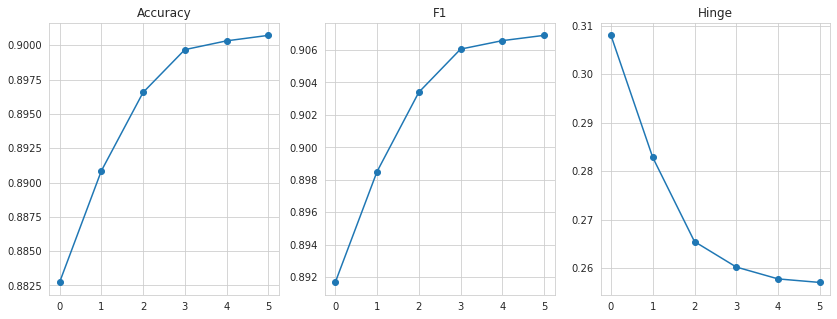

In [17]:
hashdims = [f"--bit_precision={i}" for i in range(18, 30, 2)]
scores = vw_svm_gridsearch_scores(hashdims, "--ngram=2")
plot_scores(scores)

  0%|          | 0/6 [00:00<?, ?it/s]

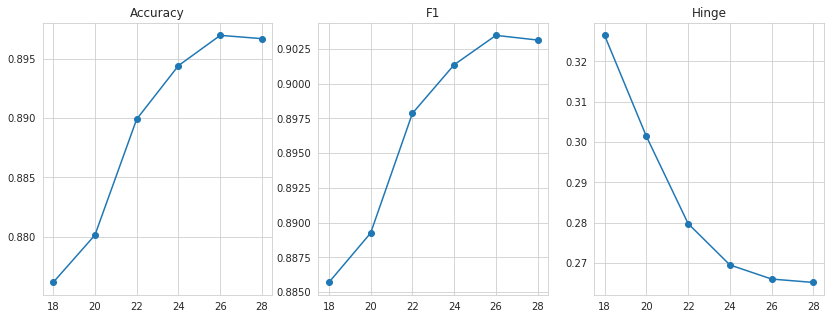

In [18]:
hashdims = [f"--bit_precision={i}" for i in range(18, 30, 2)]
scores = vw_svm_gridsearch_scores(hashdims, "--ngram=2 --ngram=3 --ngram=4")
plot_scores(scores, range(18, 30, 2))

  0%|          | 0/5 [00:00<?, ?it/s]

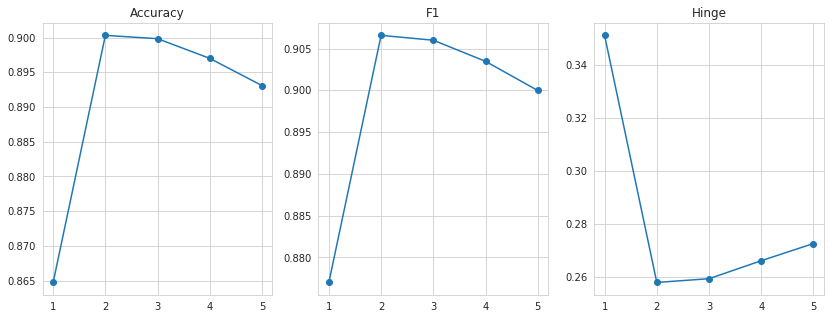

In [19]:
a = [f'--ngram={i}' for i in range(2, 7)]
ngrams = [" ".join(a[:i]) for i in range(len(a)) ]
scores = vw_svm_gridsearch_scores(ngrams, "--bit_precision=26 --binary")
plot_scores(scores, range(1, 6))

Searching for the best hashdim and ngrams combination

  0%|          | 0/12 [00:00<?, ?it/s]

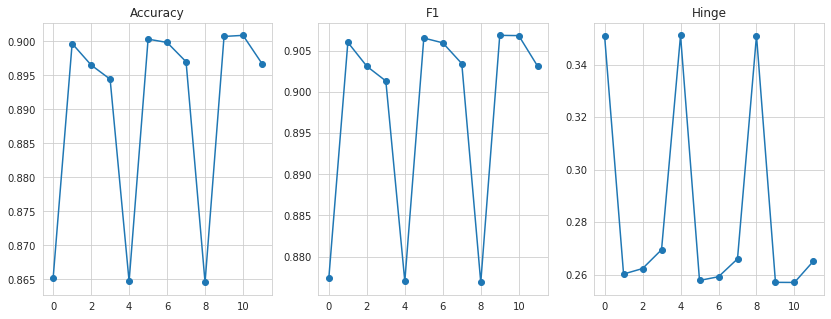

In [20]:
from itertools import product
a = [f'--ngram={i}' for i in range(2, 6)]
ngrams = [" ".join(a[:i]) for i in range(len(a))]
hashdims = [f"--bit_precision={i}" for i in range(24, 30, 2)]
search_space = [" ".join(i) for i in product(hashdims, ngrams)]
scores = vw_svm_gridsearch_scores(search_space, "--binary")
plot_scores(scores)

ngrams up to 3 and bit_precision=28 seems to be the best one

### Regularization
Let's try to add regularization, now I'm going to use `vw-hyperopt.py` (included in vw)

In [21]:
!python $TEMP/vowpal_wabbit/utl/vw-hyperopt.py \
    --train=train.vw \
    --holdout=val.vw \
    --outer_loss_function=hinge \
    --vw_space="--l2=1e-8..1e-2~LO --l1=1e-8..1e-2~LO" \
    --additional_cmd="--binary --bit_precision=28 --ngram=2 --ngram==3 --loss_function=hinge --quiet" \
    --max_eval=10

100%|███████████████████| 10/10 [20:19<00:00, 121.95s/trial, best loss: 0.19856]


In [22]:
!tail log.log -n 9

vw  -d train.vw -f ./current.model --holdout_off -c --binary --bit_precision=28 --ngram=2 --ngram==3 --loss_function=hinge --quiet  


2021-06-17 14:47:18,746 INFO     [root/vw-hyperopt:354]: 

The best holdout loss value: 
0.19856




# Final model

In [23]:
%%time
!vw --data=train.vw \
    --ngram=2 \
    --ngram=3 \
    --bit_precision=28 \
    --loss_function=hinge \
    --binary \
    --final_regressor=model.vw

# predict
!vw --initial_regressor=model.vw \
    --testonly \
    --data=val.vw \
    --ngram=2 \
    --ngram=3 \
    --binary \
    --predictions=val.pred \
    --raw_predictions=val_raw.pred

[info] Generating 2-grams for all namespaces.
[info] Generating 3-grams for all namespaces.
final_regressor = model.vw
Num weight bits = 28
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
Enabled reductions: gd, scorer, binary
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000  -1.0000      112
0.500000 0.000000            2            2.0   1.0000   1.0000       34
0.500000 0.500000            4            4.0  -1.0000   1.0000      388
0.375000 0.250000            8            8.0  -1.0000   1.0000      388
0.312500 0.250000           16           16.0   1.0000   1.0000      409
0.250000 0.187500           32           32.0   1.0000   1.0000       43
0.296875 0.343750           64           64.0   1.0000   1.0000      178
0.257812 0.218750          128          128.0  -1.0000   

In [24]:
y_true = val_df['sentiment']
y_pred = np.loadtxt('val.pred', dtype='int')
raw = np.loadtxt('val_raw.pred')
print(classification_report(y_true, y_pred, digits=4))

hinge_loss(y_true, raw)

              precision    recall  f1-score   support

          -1     0.9601    0.8366    0.8941     12500
           1     0.8552    0.9652    0.9069     12500

    accuracy                         0.9009     25000
   macro avg     0.9076    0.9009    0.9005     25000
weighted avg     0.9076    0.9009    0.9005     25000



0.25704316996000004

## Making a submission

In [25]:
!vw --initial_regressor=model.vw \
    --testonly \
    --data=test.vw \
    --ngram=2 \
    --ngram=3 \
    --binary \
    --quiet \
    --predictions=test.pred

a = np.loadtxt("test.pred", dtype='int')
a = np.where(a < 0, 0, a)
test_df['sentiment'] = a
test_df[['id','sentiment']].to_csv("submission.csv", index=False, quoting=3) # 0.97240 accuracy!!

In [26]:
!rm *.log
!rm *.pred
!rm *.json
!rm *.cache
!rm *.txt
!rm *.tsv